# investigating hypoxic control treatment

this treatment resulted in 3 pairwise comparisons with DMGs - interested if all of these DMGs are unique to hypoxia control (HC)

In [2]:
library(tidyverse)
library(ggvenn)
library(dplyr)
library(cowplot)
library(RColorBrewer)

###### for KEGG analysis ######
library(topGO)
library(KEGGREST)
library(clusterProfiler)
library(ggridges)
library(httr)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




### loading and formatting

In [3]:
# importing csv files

#1 control control vs. hypoxic control
CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/CC_vs_HC.csv')

#2 control hypoxic vs. hypoxic control
CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/CH_vs_HC.csv')

#3 hypoxic hypoxic vs. hypoxic control
HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/HH_vs_HC.csv')

#######################################

#4 hypoxic hypoxic vs. control hypoxic
HH_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/HH_vs_CH.csv')

#5 hypoxic hypoxic vs. control control
HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/CC_vs_HH.csv')

#6 control control vs. control hypoxic
CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/CC_vs_CH.csv')


pulling out significant DMGs for the three pairwise comparisons with HC (adjusted p-value < 0.05)

In [4]:
# significant DMGs

# 1. control control vs. hypoxic control
sig_CC_HC <- filter(CC_HC, CC_HC$padj < 0.05)
dim(sig_CC_HC) # 20 total sig DMGs

# 2. control hypoxic vs. hypoxic control
sig_CH_HC <- filter(CH_HC, CH_HC$padj < 0.05)
dim(sig_CH_HC) # 258 total sig DMGs

# 3. hypoxic hypoxic vs. hypoxic control
sig_HH_HC <- filter(HH_HC, HH_HC$padj < 0.05)
dim(sig_HH_HC) # 124 total sig DMGs

[1] 12  7

[1] 196   7

[1] 77  7

In [5]:
# significant DMGs

# 4. hypoxic hypoxic vs. control hypoxic
sig_HH_CH <- filter(HH_CH, HH_CH$padj < 0.05)
dim(sig_HH_CH) # 0 total sig DMGs

# 5. hypoxic hypoxic vs. control control
sig_HH_CC <- filter(HH_CC, HH_CC$padj < 0.05)
dim(sig_HH_CC) # 2 total sig DMGs

# 6. control control vs. control hypoxic
sig_CC_CH <- filter(CC_CH, CC_CH$padj < 0.05)
dim(sig_CC_CH) # 1 total sig DMGs

[1] 0 7

[1] 1 7

[1] 1 7

In [6]:
sig_CC_CH

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111100699,13.59616,1.958284,0.3546143,4.817301,1.455128e-06,0.03538143


In [7]:
sig_HH_CC

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111100699,13.59616,2.087349,0.3509947,5.234691,1.652615e-07,0.004018332


adding columns to the dfs - need to assign which direction the methylation is in order to assign colors in the plots - also adding a column to denote what the pairwise comparison is in case I end up combining dataframes and faceting by this later on... 

In [6]:
# column 'pair' to denote the pairwise comparison this data is originally from 
CC_HC$pair <- 'CC_HC' #1
CH_HC$pair <- 'CH_HC' #2
HH_HC$pair <- 'HH_HC' #3
HH_CH$pair <- 'HH_CH' #4
HH_CC$pair <- 'HH_CC' #5
CC_CH$pair <- 'CC_CH' #6

In [7]:
#1 control control vs. hypoxic control
CC_HC$methyl <- ifelse(CC_HC$log2FoldChange<0 & CC_HC$padj < 0.05, "CC", 
                        ifelse(CC_HC$log2FoldChange>0 & CC_HC$padj < 0.05, "HC", 
                               "not significant"))

#2 control hypoxic vs. hypoxic control
CH_HC$methyl <- ifelse(CH_HC$log2FoldChange<0 & CH_HC$padj < 0.05, "CH", 
                        ifelse(CH_HC$log2FoldChange>0 & CH_HC$padj < 0.05, "HC", 
                               "not significant"))

#3 hypoxic hypoxic vs. hypoxic control
HH_HC$methyl <- ifelse(HH_HC$log2FoldChange<0 & HH_HC$padj < 0.05, "HC", 
                        ifelse(HH_HC$log2FoldChange>0 & HH_HC$padj < 0.05, "HH", 
                               "not significant"))

#4 hypoxic hypoxic vs. control hypoxic
HH_CH$methyl <- ifelse(HH_CH$log2FoldChange<0 & HH_CH$padj < 0.05, "CH",
                        ifelse(HH_CH$log2FoldChange>0 & HH_CH$padj < 0.05, "HH", 
                               "not significant"))

#5 hypoxic hypoxic vs. control control
HH_CC$methyl <- ifelse(HH_CC$log2FoldChange<0 & HH_CC$padj < 0.05, "CC", 
                        ifelse(HH_CC$log2FoldChange>0 & HH_CC$padj < 0.05, "HH", 
                               "not significant"))



#6 control control vs. control hypoxic
CC_CH$methyl <- ifelse(CC_CH$log2FoldChange<0 & CC_CH$padj < 0.05, "CC", 
                        ifelse(CC_CH$log2FoldChange>0 & CC_CH$padj < 0.05, "CH", 
                               "not significant"))


### add gene names/meta data to significant DMGs in pairwise comparisons

From the Index of *C. virginica* genomes/annotations page ([link](https://ftp.ncbi.nlm.nih.gov/genomes/all/annotation_releases/6565/100/GCF_002022765.2_C_virginica-3.0/))

I downloaded the file `GCF_002022765.2_C_virginica-3.0_feature_table` - since only the mRNA lines had gene names (gene products), I first removed empty rows for those and then removed duplicate rows for the gene_id - that csv is what is being loaded here, with the idea that I can provide a list of sig. genes from a pairwise comparison and add gene names to that list

In [9]:
gene_products <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/GCF_CV_gene_products.csv')
head(gene_products)

,X..feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<lgl>,<int>,<int>,<chr>
1,gene,lncRNA,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,13578,14594,+,,NA,,,LOC111116054,111116054,NA,1017,NA,
2,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,28961,33324,+,XM_022471938.1,NA,XP_022327646.1,UNC5C-like protein,LOC111126949,111126949,NA,2254,2254,
3,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,43111,66897,-,XM_022447324.1,NA,XP_022303032.1,"FMRFamide receptor-like, transcript variant X1",LOC111110729,111110729,NA,1489,1489,
4,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,85606,95254,-,XM_022449924.1,NA,XP_022305632.1,homeobox protein Hox-B7-like,LOC111112434,111112434,NA,1023,1023,
5,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,99840,106460,+,XM_022461698.1,NA,XP_022317406.1,ribulose-phosphate 3-epimerase-like,LOC111120752,111120752,NA,1070,1070,
6,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,108305,110077,-,XM_022474921.1,NA,XP_022330629.1,mucin-19-like,LOC111128944,111128944,NA,1773,1773,partial


In [10]:
# 1. control control vs. hypoxic control
#gene_products[gene_products$symbol %in% sig_CC_HC$X,]

colnames(sig_CC_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_HC_genes <- merge(sig_CC_HC, gene_products, by='symbol')
sig_CC_HC_genes <- select(sig_CC_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

#write.csv(sig_CC_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_HC_genes.csv')


head(sig_CC_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7"
2,LOC111115023,20.27520,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023
3,LOC111117745,123.41704,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5"
4,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
5,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1"
6,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3"


In [11]:
# 2. control hypoxic vs. hypoxic control
colnames(sig_CH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CH_HC_genes <- merge(sig_CH_HC, gene_products, by='symbol')
sig_CH_HC_genes <- select(sig_CH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

#write.csv(sig_CH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CH_HC_genes.csv')



head(sig_CH_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,-1.2672684,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17
2,LOC111099571,31.11937,-1.4181929,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like
3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.0332446433,lys-63-specific deubiquitinase BRCC36-like
4,LOC111099930,35.09830,-1.1981548,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1"
5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.0390971051,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
6,LOC111100608,22.90296,-1.4622657,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like


In [12]:
# 3. hypoxic hypoxic vs. hypoxic control
colnames(sig_HH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_HC_genes <- merge(sig_HH_HC, gene_products, by='symbol')
sig_HH_HC_genes <- select(sig_HH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

#write.csv(sig_HH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_HC_genes.csv')



head(sig_HH_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17
2,LOC111099571,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like
3,LOC111099930,35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111100608,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like
5,LOC111101237,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1
6,LOC111101984,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like


4. hypoxic hypoxic vs. control hypoxic

no sig. DMGs


In [13]:
# 5. hypoxic hypoxic vs. control control
colnames(sig_HH_CC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_CC_genes <- merge(sig_HH_CC, gene_products, by='symbol')
sig_HH_CC_genes <- select(sig_HH_CC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

#write.csv(sig_HH_CC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_CC_genes.csv')



head(sig_HH_CC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,13.59616,2.087349,0.3509947,5.234691,1.652615e-07,0.004018332,methylthioribulose-1-phosphate dehydratase-like


In [14]:
# 6. control control vs. control hypoxic
colnames(sig_CC_CH) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_CH_genes <- merge(sig_CC_CH, gene_products, by='symbol')
sig_CC_CH_genes <- select(sig_CC_CH_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

#write.csv(sig_CC_CH_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_CH_genes.csv')



head(sig_CC_CH_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,13.59616,1.958284,0.3546143,4.817301,1.455128e-06,0.03538143,methylthioribulose-1-phosphate dehydratase-like


### Venn diagram of all sig. DMGs

In [5]:
sig_CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs/sig_CC_HC_genes.csv')
sig_CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs/sig_CH_HC_genes.csv')
sig_HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs/sig_HH_HC_genes.csv')

sig_HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs/sig_HH_CC_genes.csv')
sig_CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs/sig_CC_CH_genes.csv')

head(sig_CC_HC)

,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7"
2,2,LOC111115023,20.27520,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023
3,3,LOC111117745,123.41704,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5"
4,4,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
5,5,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1"
6,6,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3"


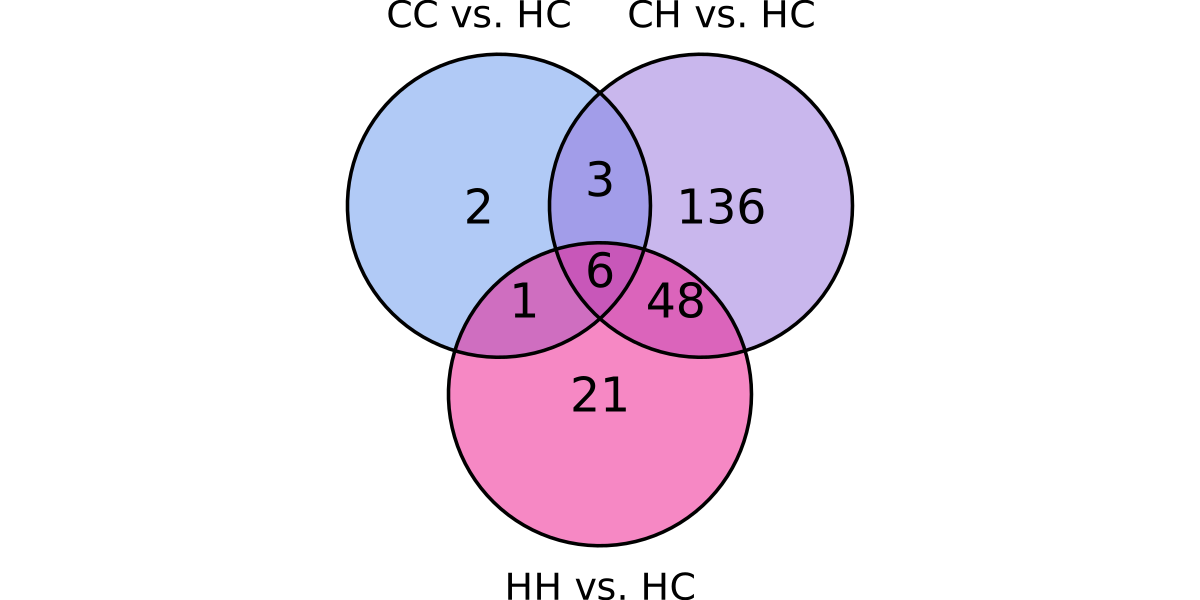

In [57]:

x = list(A = sig_CC_HC$symbol,
         B = sig_CH_HC$symbol, 
         C = sig_HH_HC$symbol)

names(x) <- c('CC vs. HC',
              'CH vs. HC',
              'HH vs. HC')

# same colors as used in the volcano plots
custom_colors <- c('cornflowerblue',  'mediumpurple', 'deeppink2')

venn <- ggvenn(x,
      set_name_size = 8,
       text_size = 10,
       show_percentage = FALSE,
      fill_color = custom_colors)

venn

In [23]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/DMG_venn_numb.pdf', venn)

Saving 6.67 x 6.67 in image


what about all sig. DMGs (even in comparisons outside of HC)

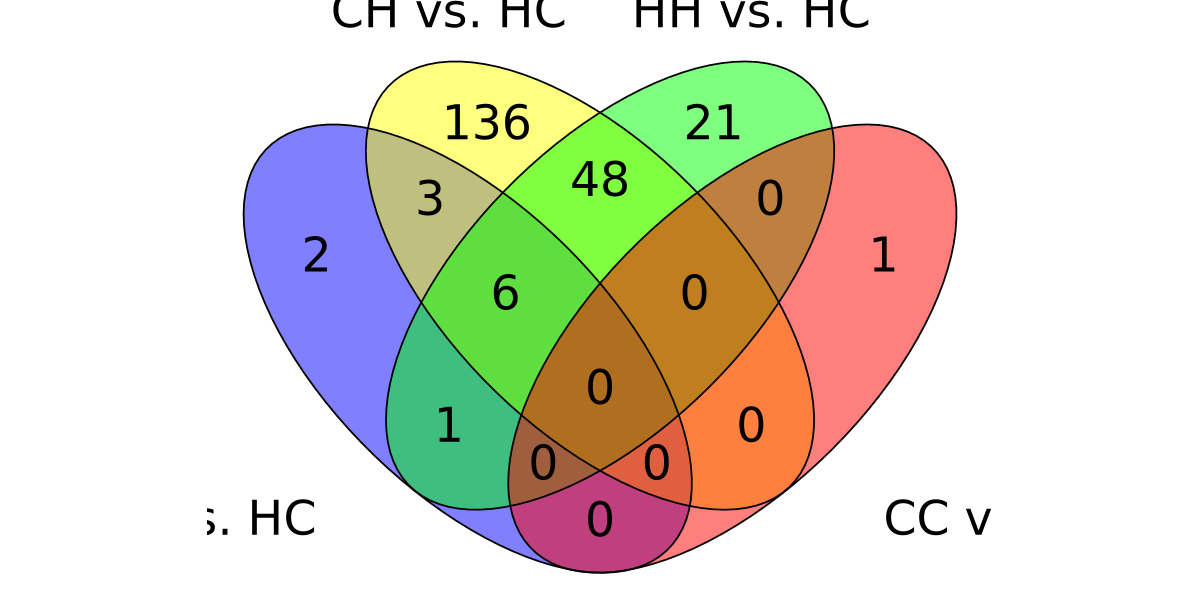

In [18]:
options(repr.plot.width=10, repr.plot.height=5)

x = list(A = sig_CC_HC$symbol,
         B = sig_CH_HC$symbol, 
         C = sig_HH_HC$symbol,
        D = sig_HH_CC$symbol,
        E = sig_CC_CH$symbol)

names(x) <- c('CC vs. HC',
              'CH vs. HC',
              'HH vs. HC',
             'CC vs. HH', 
             'CC vs. CH')

# same colors as used in the volcano plots
#custom_colors <- c('cornflowerblue',  'mediumpurple', 'deeppink2')

venn <- ggvenn(x,
      set_name_size = 10,
       text_size = 10,
      stroke_size = 0.5, 
       show_percentage = FALSE)
      #fill_color = custom_colors)

venn

### shared sig DMGs for the pairwise comparisons

In [35]:
# pulling out the 14 shared genes

# Merge the data frames on the 'gene' column
shared_genes6 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes, sig_HH_HC_genes))

shared_genes6 <- as.data.frame(shared_genes6)
                    
# View the result
dim(shared_genes6)


[1]  6 22

In [36]:
shared_genes6

symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,⋯,pvalue.y,padj.y,name.y,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.023503416,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,-1.351404,⋯,1.504690e-04,1.631844e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,1.356759,0.2882152,3.840044,1.230124e-04,2.639809e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.042257323,"calcyphosin-like protein, transcript variant X3",13.31739,-1.898432,⋯,1.012038e-07,1.107538e-04,"calcyphosin-like protein, transcript variant X3",13.31739,2.084902,0.2990502,6.135765,8.475033e-10,5.101122e-06,"calcyphosin-like protein, transcript variant X3"
LOC111123492,43.91933,-1.264591,0.2211555,-4.587681,4.481962e-06,0.016845456,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,-1.590124,⋯,5.947551e-10,3.579831e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,1.565953,0.2081032,6.323557,2.556094e-10,3.077026e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11"
LOC111124674,17.57497,-1.406706,0.2805413,-4.123123,3.737706e-05,0.036303375,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,-1.408187,⋯,3.273030e-05,5.438185e-03,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,1.589960,0.2664452,5.029027,4.929756e-07,6.171045e-04,"gamma-glutamyltranspeptidase 1-like, transcript variant X1"
LOC111129146,22.23491,1.342719,0.2551562,4.282548,1.847653e-05,0.023503416,FERM domain-containing protein 8-like,22.23491,1.463103,⋯,1.978316e-06,7.004403e-04,FERM domain-containing protein 8-like,22.23491,-1.633663,0.2432214,-5.688903,1.278579e-08,3.651925e-05,FERM domain-containing protein 8-like
LOC111133438,21.61303,-1.806478,0.3140663,-4.955889,7.200032e-07,0.005412264,uncharacterized LOC111133438,21.61303,-1.558558,⋯,3.297786e-05,5.438185e-03,uncharacterized LOC111133438,21.61303,1.949220,0.3058639,5.555479,2.768520e-08,5.554574e-05,uncharacterized LOC111133438


In [37]:
# adding info for what pairwise comparisons for HC these genes show up for
shared_genes6$pair <- 'CH, HH, CC'

all of these except for LOC111133438 were in the original analysis - should make a venn diagram of overlap between exon features-to-meta features and new analysis with gene body methylation

In [38]:
write.csv(shared_genes6, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/6shared_genes.csv')

pulling out the **54 shared genes between HH vs. HC and CH vs. HC**

In [39]:
# pulling out the 54 shared genes

# Merge the data frames on the 'gene' column
shared_genes54 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CH_HC_genes, sig_HH_HC_genes))
                    
shared_genes54 <- as.data.frame(shared_genes54)

# View the result
dim(shared_genes54)


[1] 54 15

In [40]:
# adding info for what pairwise comparisons for HC these genes show up for
shared_genes54$pair <- 'CH, HH'

In [41]:
head(shared_genes54)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111099548,42.98619,-1.267268,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17,"CH, HH"
2,LOC111099571,31.11937,-1.418193,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like,"CH, HH"
3,LOC111099930,35.09830,-1.198155,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1",35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1","CH, HH"
4,LOC111100608,22.90296,-1.462266,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like,"CH, HH"
5,LOC111101237,37.09165,-1.139884,0.2019498,-4.406461,1.050732e-05,0.0024801387,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,"CH, HH"
6,LOC111101984,10.15872,-1.767496,0.3372300,-4.499884,6.799068e-06,0.0018601633,von Willebrand factor D and EGF domain-containing protein-like,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like,"CH, HH"


pulling out the **48 genes shared ONLY between HH vs. HC and CH vs. HC**

In [42]:
# to remove the 6 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes48 <- shared_genes54[!shared_genes54$symbol %in% shared_genes6$symbol, ]
dim(shared_genes48)

[1] 48 16

In [43]:
# adding info for what pairwise comparisons for HC these genes show up for
shared_genes48$pair <- 'CH, HH'

In [44]:
head(shared_genes48)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111099548,42.98619,-1.267268,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17,"CH, HH"
2,LOC111099571,31.11937,-1.418193,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like,"CH, HH"
3,LOC111099930,35.09830,-1.198155,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1",35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1","CH, HH"
4,LOC111100608,22.90296,-1.462266,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like,"CH, HH"
5,LOC111101237,37.09165,-1.139884,0.2019498,-4.406461,1.050732e-05,0.0024801387,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,"CH, HH"
6,LOC111101984,10.15872,-1.767496,0.3372300,-4.499884,6.799068e-06,0.0018601633,von Willebrand factor D and EGF domain-containing protein-like,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like,"CH, HH"


In [45]:
write.csv(shared_genes48, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/48shared_genes.csv')

pulling out the **9 genes shared bewteen CC vs. HC and CH vs. HC**

In [46]:
# pulling out the 9 shared genes

# Merge the data frames on the 'gene' column
shared_genes9 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes))  
shared_genes9 <- as.data.frame(shared_genes9)

dim(shared_genes9)

[1]  9 15

In [47]:
head(shared_genes9)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7",497.52024,-1.016149,0.2108982,-3.632792,2.803705e-04,2.376831e-02,"uncharacterized LOC111103344, transcript variant X7"
2,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,-1.351404,0.2905854,-3.790294,1.504690e-04,1.631844e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
3,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3",13.31739,-1.898432,0.3095909,-5.324549,1.012038e-07,1.107538e-04,"calcyphosin-like protein, transcript variant X3"
4,LOC111123492,43.91933,-1.264591,0.2211555,-4.587681,4.481962e-06,0.01684546,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,-1.590124,0.2164348,-6.191815,5.947551e-10,3.579831e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11"
5,LOC111124674,17.57497,-1.406706,0.2805413,-4.123123,3.737706e-05,0.03630337,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,-1.408187,0.2788402,-4.153588,3.273030e-05,5.438185e-03,"gamma-glutamyltranspeptidase 1-like, transcript variant X1"
6,LOC111129146,22.23491,1.342719,0.2551562,4.282548,1.847653e-05,0.02350342,FERM domain-containing protein 8-like,22.23491,1.463103,0.2550880,4.755627,1.978316e-06,7.004403e-04,FERM domain-containing protein 8-like


pulling out the **3 genes shared between ONLY CC vs. HC and CH vs. HC**

In [48]:
# to remove the 3 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes3 <- shared_genes9[!shared_genes9$symbol %in% shared_genes6$symbol, ]
dim(shared_genes3)

[1]  3 15

In [49]:
# adding info for what pairwise comparisons for HC these genes show up for
shared_genes3$pair <- 'CH, CC'

In [50]:
head(shared_genes3)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111103344,497.52024,-1.1930798,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7",497.52024,-1.016149,0.2108982,-3.632792,2.803705e-04,0.0237683108,"uncharacterized LOC111103344, transcript variant X7","CH, CC"
7,LOC111132100,25.78011,-1.3964117,0.2804168,-4.088242,4.346553e-05,0.03630337,"uncharacterized LOC111132100, transcript variant X3",25.78011,-1.590381,0.2776263,-4.828004,1.379080e-06,0.0005929060,"uncharacterized LOC111132100, transcript variant X3","CH, CC"
9,LOC111133874,106.76763,-0.9820156,0.1780116,-4.112179,3.919417e-05,0.03630337,uncharacterized LOC111133874,106.76763,-1.154486,0.1763009,-5.130353,2.891988e-07,0.0001934097,uncharacterized LOC111133874,"CH, CC"


In [51]:
write.csv(shared_genes3, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/3shared_genes.csv')

shared gene between **CC vs. HC and HH vs. HC**

In [52]:
shared_gene7 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_HH_HC_genes))
shared_gene1 <- shared_gene7[!shared_gene7$symbol %in% shared_genes6$symbol, ]                     
dim(shared_gene1)

[1]  1 15

In [53]:
# adding info for what pairwise comparisons for HC these genes show up for
shared_gene1$pair <- 'CC, HH'

In [54]:
shared_gene1

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1",19.27594,1.556436,0.3455086,3.781196,0.000156077,0.02870595,"exocyst complex component 7-like, transcript variant X1","CC, HH"


### unique sig DMGs for pairwise comparison

pulling out the **173 unique sig DMGs for CH vs. HC**

In [55]:
unique_CH_HC <- sig_CH_HC_genes[!sig_CH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_genes48$symbol), ]
dim(unique_CH_HC)

[1] 136   8

In [56]:
# adding info for what pairwise comparisons for HC these genes show up for
unique_CH_HC$pair <- 'CH'

In [57]:
head(unique_CH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.033244643,lys-63-specific deubiquitinase BRCC36-like,CH
5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.039097105,"oncoprotein-induced transcript 3 protein-like, transcript variant X1",CH
7,LOC111100625,38.39518,-1.2060788,0.2621809,-3.646638,2.656942e-04,0.023517848,"succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial-like, transcript variant X2",CH
8,LOC111100898,38.34191,-1.3046636,0.2438064,-4.325825,1.519623e-05,0.003201238,"uncharacterized LOC111100898, transcript variant X3",CH
9,LOC111100915,20.55756,1.6529072,0.3015883,4.651730,3.291615e-06,0.001037820,"uncharacterized LOC111100915, transcript variant X2",CH
11,LOC111101375,40.32033,-1.2280407,0.2367017,-4.131955,3.596914e-05,0.005773287,mu-type opioid receptor-like,CH


In [58]:
write.csv(unique_CH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/139unique_genes_CHvHC.csv')

pulling out the **2 unique sig DMGs for CC vs. HC**

In [59]:
unique_CC_HC <- sig_CC_HC_genes[!sig_CC_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_gene1$symbol), ]
dim(unique_CC_HC)

[1] 2 8

In [60]:
# adding info for what pairwise comparisons for HC these genes show up for
unique_CC_HC$pair <- 'CC'

In [61]:
head(unique_CC_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,LOC111115023,20.2752,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023,CC
3,LOC111117745,123.4170,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5",CC


In [62]:
write.csv(unique_CC_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/2unique_genes_CCvHC.csv')

pulling out the **22 unique sig DMGs for HH vs. HC**

In [63]:
unique_HH_HC <- sig_HH_HC_genes[!sig_HH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes48$symbol, shared_gene1$symbol), ]
dim(unique_HH_HC)

[1] 21  8

In [64]:
# adding info for what pairwise comparisons for HC these genes show up for
unique_HH_HC$pair <- 'HH'

In [65]:
head(unique_HH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
9,LOC111106272,26.730416,1.444594,0.2630936,4.540567,5.610309e-06,0.003069859,UDP-xylose and UDP-N-acetylglucosamine transporter-like,HH
11,LOC111106920,20.924617,1.461400,0.3262911,3.712636,2.051118e-04,0.035784586,plasma alpha-L-fucosidase-like,HH
13,LOC111109361,22.421224,1.332604,0.2694038,4.018519,5.856517e-05,0.014280548,fucolectin-like,HH
14,LOC111109809,2.629455,1.698251,0.3601734,4.020982,5.795609e-05,0.014280548,peroxisome proliferator-activated receptor delta-like,HH
16,LOC111110897,42.967001,-1.312697,0.2770241,-3.836117,1.249951e-04,0.026398089,"E3 ubiquitin-protein ligase TRIM71-like, transcript variant X1",HH
22,LOC111115873,8.605695,1.535518,0.3373803,3.810293,1.388020e-04,0.027864621,"uncharacterized LOC111115873, transcript variant X2",HH


In [66]:
write.csv(unique_HH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/22unique_genes_HHvHC.csv')

Now have multiple dfs that contain shared and unique sig DMGs from the Venn diagram of pairwise comparisons with HC

**Shared sig DMGs**:
- shared_genes14 - shared between all 3 comparisons
- shared_genes67 - shared *ONLY* between HH vs. HC and CH vs. HC
- shared_genes81 - shared between HH vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes18 - shared between CC vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes4 - shared *ONLY* between CC vs. HC and CH vs. HC

**Unique sig DMGs**:
- unique_HH_HC - 43 sig DMGs
- unique_CH_HC - 173 sig DMGs
- unique_CC_HC - 2 sig DMGs

#### creating master df for sig. DMGs

In [67]:
# formatting dfs for merging

# shared genes 6
sg6 <- select(shared_genes6, symbol, name.x, pair)
colnames(sg6) <- c('symbol', 'name', 'pair')

# shared genes 48
sg48 <- select(shared_genes48, symbol, name.x, pair)
colnames(sg48) <- c('symbol', 'name', 'pair')

# shared genes 3
sg3 <- select(shared_genes3, symbol, name.x, pair)
colnames(sg3) <- c('symbol', 'name', 'pair')

# shared genes 3
sg1 <- select(shared_gene1, symbol, name.x, pair)
colnames(sg1) <- c('symbol', 'name', 'pair')

# unique for CC vs. HC
uCC <- select(unique_CC_HC, symbol, name, pair)

# unique for HH vs. HC
uHH <- select(unique_HH_HC, symbol, name, pair)

# unique for CH vs. HC
uCH <- select(unique_CH_HC, symbol, name, pair)

In [68]:
all_sigDMGs <- rbind(sg6, sg48, sg3, sg1, uCC, uHH, uCH)
head(all_sigDMGs)

,symbol,name,pair
,<chr>,<chr>,<chr>
1,LOC111117760,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3","CH, HH, CC"
2,LOC111119327,"calcyphosin-like protein, transcript variant X3","CH, HH, CC"
3,LOC111123492,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11","CH, HH, CC"
4,LOC111124674,"gamma-glutamyltranspeptidase 1-like, transcript variant X1","CH, HH, CC"
5,LOC111129146,FERM domain-containing protein 8-like,"CH, HH, CC"
6,LOC111133438,uncharacterized LOC111133438,"CH, HH, CC"


In [69]:
write.csv(all_sigDMGs, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/all_sigDMGs.csv', row.names = FALSE)